# Homework 2

## Background. Fourth-Order Multi-Input Multi-Output Model

The next step in the evolution of our model for the temperature control lab is to incorporate the both heater/sensor assemblies into a unified model. The base assumptions for this model are:

* The two heater/sensor assemblies are identical. Values for heat capacities $C_p^H$ and $C_p^S$ and heat transfer coefficients $U_a$ and $U_b$ are the same for both assemblies.
* Heat transfer between the two assemblies is proportional to the difference $T_{H,1} - T_{H_2}$ with a heat transfer coefficient $U_c$.

Given the assumptions, a model for the combined system of two heater/sensors assemblies is given by


$$
\begin{align}
C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + U_c(T_{H,2}-T_{H,1})  + \alpha P_1u_1\\
C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1})  \\
C^H_p\frac{dT_{H,2}}{dt} & = U_a(T_{amb} - T_{H,2}) + U_b(T_{S,2} - T_{H,2}) + U_c(T_{H,1}-T_{H,2}) + \alpha P_2 u_2\\
C^S_p\frac{dT_{S,2}}{dt} & = U_b(T_{H,2} - T_{S,2}) 
\end{align}
$$

where the temperatures measured in an experiment, $T_1$ and $T_2$, are equal to the sensor temperatures of the model. That is

$$
\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}
$$

We can rewrite the equations in a format for `solve_ivp`.

$$
\begin{align}
\frac{dT_{H,1}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})(T_{H,1} - T_{amb}) + \frac{U_b}{C^H_p}(T_{S,1} - T_{amb}) + \frac{U_c}{C^H_p}(T_{H,2} - T_{amb})  + \frac{\alpha P_1}{C^H_p}u_1\\
\frac{dT_{S,1}}{dt} & = \frac{U_b}{C^S_p}(T_{H,1} - T_{S,1})  \\
\frac{dT_{H,2}}{dt} & = -(\frac{U_a+U_b+U_c}{C^H_p})(T_{H,2} - T_{amb}) + \frac{U_b}{C^H_p}(T_{S,2} - T_{amb}) + \frac{U_c}{C^H_p}(T_{H,1} - T_{amb})  + \frac{\alpha P_2}{C^H_p}u_2\\
\frac{dT_{S,2}}{dt} & = \frac{U_b}{C^S_p}(T_{H,2} - T_{S,2}) 
\end{align}
$$

where

$$
\begin{align}
T_1 & = T_{S,1} \\
T_2 & = T_{S,2}
\end{align}
$$

You can use this model to answer the following questions.

## Problem 1. Convert to State Space

Following the development above, we define state space inputs $u$, states $x$, and output measurements $y$ as follows:

$$
\begin{align}
u & = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} \\
\\
x & = \begin{bmatrix} T_{H_1} - T_{amb} \\ T_{S,1} - T_{amb} \\ T_{H,2} - T_{amb} \\ T_{S,2} - T_{amb} \end{bmatrix} \\
\\
y & = \begin{bmatrix} T_{S,1} - T_{amb} \\ T_{S,2} - T_{amb} \end{bmatrix} \\
\end{align}
$$

Derive expressions for $A$, $B$, and $C$ such that four state model reduces to the form

$$
\begin{align}
\frac{dx}{dt} & = A x + B u \\
y & = C x
\end{align}
$$

You may do this analytical work by hand on paper and submit a scan as a separate .pdf file (You're also welcome to submit your work as a math formatted notebook, but that is not required.)

**(a)** What are the dimensions of $A$, $B$, and $C$?

**(b)** Derive expressions for the matrices $A$, $B$, and $C$.

## Problem 2. Simulate Step Response and Compare to Data

The next step in model fitting is create a simulation model for the new four-state model. Below is code that will read an experimental data set, perform a simulation for a specified choice of parameters, and plot the simulated and measured responses on the same chart.

**(a)** Change the import statement to import the data you collected for your device. Adjust parameters to match the conditions (i.e, $T_{amb}$ and initial conditions) corresponding to your experimental data collection.

**(b)** By trial and error, attempt to set values for the adjustable parameters to match the model to your data. Keep trying until your model matches experiment to within, say, 5 degrees. The learning goal is for you to develop some intuition about the relationship between heat capacities and the heat transfer coefficients the behavior of the device. 

In [9]:
# code to read experimental data
import pandas as pd

data_file = "https://raw.githubusercontent.com/jckantor/cbe30338-book/main/notebooks/data/tclab-data-example.csv"
data = pd.read_csv(data_file)
data = data.set_index("Time")

<AxesSubplot: xlabel='Time'>

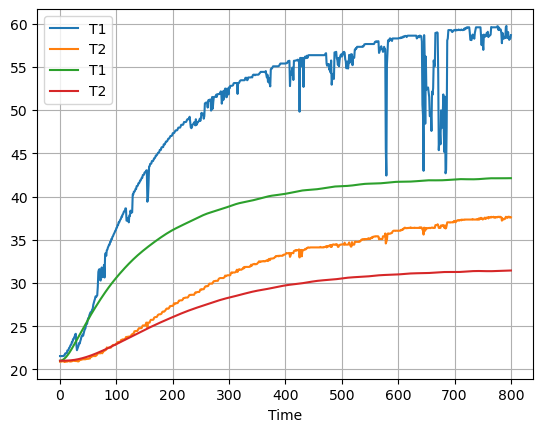

In [11]:
import numpy as np
from scipy.integrate import solve_ivp

# known parameters
T_amb = 21             # deg C
alpha = 0.00016        # watts / (units P1 * percent U1)
P1 = 200               # P1 units
U1 = 50                # steady state value of u1 (percent)
P2 = 100               # P2 units
U2 = 0                 # steady state value of u1 (percent)

# adjustable parameters
CpH = 8                # joules/deg C
CpS = 1                # joules/deg C
Ua = 0.05              # watts/deg C
Ub = 0.05              # watts/deg C
Uc = 0.05              # watts/deg C

# match time grid to experiment
t_expt = data.index

def tclab_ode_4(param):
    # unpack the adjustable parameters
    CpH, CpS, Ua, Ub, Uc = param  

    # model solution
    def deriv(t, y):
        T1H, T1S, T2H, T2S= y
        dT1H = (-(Ua + Ub + Uc)*(T1H - T_amb) + Ub*(T1S - T_amb) + Uc*(T2H - T_amb) + alpha*P1*U1)/CpH
        dT1S = Ub*(T1H - T1S)/CpS
        dT2H = (-(Ua + Ub + Uc)*(T2H - T_amb) + Ub*(T2S - T_amb) + Uc*(T1H - T_amb) + alpha*P2*U2)/CpH
        dT2S = Ub*(T2H - T2S)/CpS
        return [dT1H, dT1S, dT2H, dT2S]

    soln = solve_ivp(deriv, [min(t_expt), max(t_expt)], [T_amb]*4, t_eval=t_expt) 
    
    # create dataframe with predictions
    pred = pd.DataFrame(t_expt, columns=["Time"])
    pred["TH1"] = soln.y[0]
    pred["TS1"] = soln.y[1]
    pred["TH2"] = soln.y[2]
    pred["TS2"] = soln.y[3]
    
    pred["T1"] = pred["TS1"]
    pred["T2"] = pred["TS2"]
    
    return pred
    
pred = tclab_ode_4([CpH, CpS, Ua, Ub, Uc])

ax = data.plot(y=["T1", "T2"])
pred.plot(y = ["T1", "T2"], ax=ax, grid=True)

## Problem 3. State Space Simulation

Consult Section 2.5.3 of the notes to guide your work.

**(a)** Add a cell to evaluate matrices $A$, $B$, and $C$, and print the matrices.

**(b)** Open a new cell below, and copy and paste the simulation from Problemm 2, and modify the code to perform the same simulation using the state space model and matrices you derived for Problemm 1.  

## Problem 4. Least Squares

**(a)** Following Section 2.5.4, use least squares regression to fit the state space simulation model to your experimental data. Use the default loss function (i.e., normal least squares). Report the values of the adjustable parameters.

**(b)** Repeat part (a) using `soft_l1`, `huber`, and `cauchy` loss functions. In your engineering judgement, which loss function gives you the best result?  (There may be no single right answer).